# Lectura y Análisis

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error

# Missing values
from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator

## Carga de datos

### Lectura de ficheros

Se leen los distintos fichero con la información meteorlógica.

Se establece una cota temporal a los datos de todos los ficheros.

In [13]:
dataframes = {}

def load(file, directory, start_date=None, end_date=None):
    file_path = directory + file
    file_key = file.replace(".csv", "")  # Remove .csv extension for index
    print(f"Processing {file}...")
    
    try:
        df = pd.read_csv(file_path, parse_dates=['ts'], index_col='ts')
        df = df.sort_index()
        df_hourly = df.resample('h').mean()  # Resample by hour
        
        # Apply date filtering if start_date and end_date are provided
        if start_date and end_date:
            df_hourly = df_hourly.loc[start_date:end_date]
        
        dataframes[file_key] = df_hourly
    except Exception as e:
        print(f"Error processing {file}: {e}")

In [14]:
# Read the CSV files
directory = "data/"
orotava_openmetoe_arpege = "openmeteo_orotava_arpege.csv"
orotava_openmetoe_icon = "openmeteo_orotava_icon.csv"

orotava_grafcan = "grafcan_orotava.csv"

#########
# Dates #
#########
start_date = "2023-03-01"
end_date = "2025-02-28"

data_files = [orotava_openmetoe_arpege,
              orotava_openmetoe_icon,
              orotava_grafcan]
for file in data_files:
    load(file, directory, start_date, end_date)


Processing openmeteo_orotava_arpege.csv...
Processing openmeteo_orotava_icon.csv...
Processing grafcan_orotava.csv...


## Visualización

In [15]:
def plot_datasets(datasets, column):
    """
    Plot a specific column from each dataset (given as a list of filenames)
    for all common years.
    
    Parameters:
        datasets (list): List of dataset filenames (e.g., ['file1.csv', 'file2.csv', ...]).
        column (str): The column name to plot from each dataset.
    """
    # Remove .csv extension if present and check if each dataset is loaded
    dataset_names = [name.replace(".csv", "") for name in datasets]
    for name in dataset_names:
        if name not in dataframes:
            print(f"Dataset '{name}' is not loaded.")
            return

    # Retrieve the dataframes
    dfs = [dataframes[name] for name in dataset_names]

    # Align all dataframes on their timestamps by concatenating on axis=1 (inner join ensures common timestamps)
    # Using keys creates a hierarchical column index: top level is dataset name, lower level is the original columns.
    combined = pd.concat(dfs, axis=1, join='inner', keys=dataset_names)
    
    # Ensure the indicated column exists in every dataset
    for name in dataset_names:
        if column not in combined[name].columns:
            print(f"Column '{column}' not found in dataset '{name}'.")
            return

    # Get all common years from the combined index
    common_years = combined.index.year.unique()
    
    # Plot the indicated column for each dataset by year
    for year in common_years:
        df_year = combined[combined.index.year == year]
        plt.figure(figsize=(10, 6))
        for name in dataset_names:
            plt.plot(df_year.index, df_year[name][column],
                     label=f"{name}", linestyle='-', alpha=0.7)
        plt.title(f'Comparison Plot - Column "{column}" - Year {year}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()


### OpenMeteo

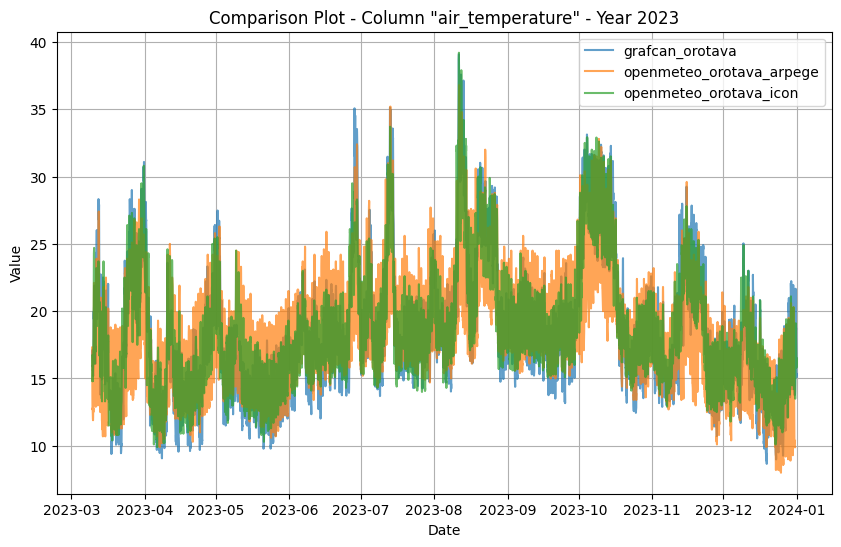

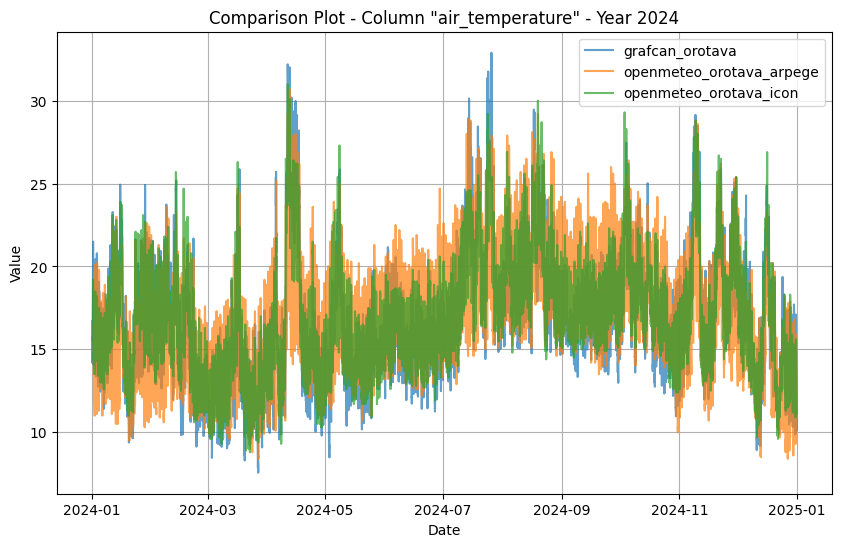

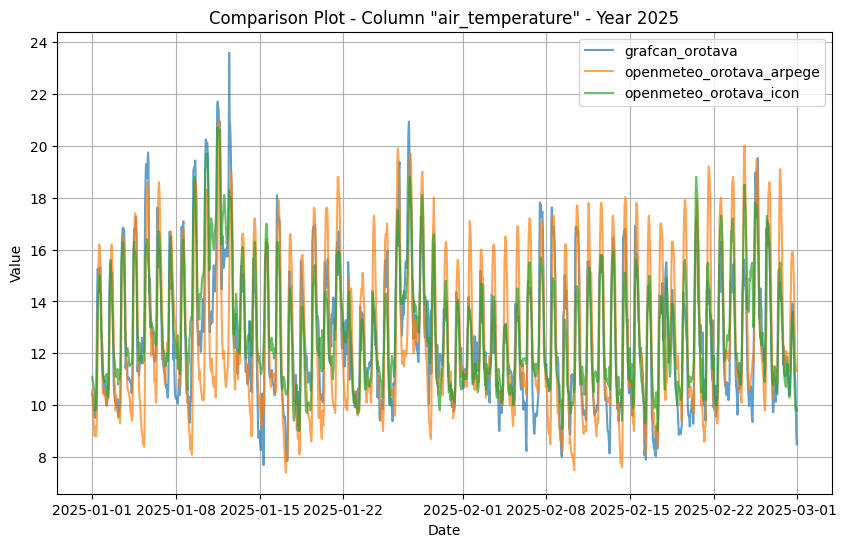

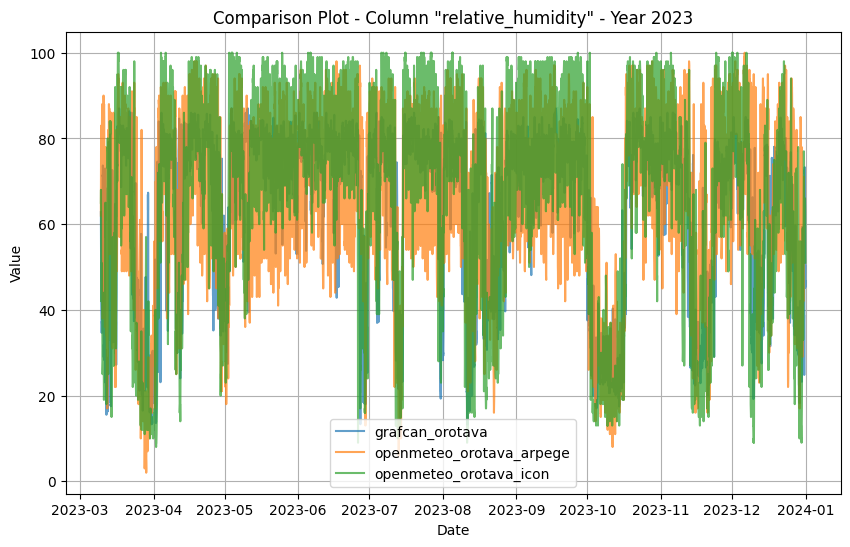

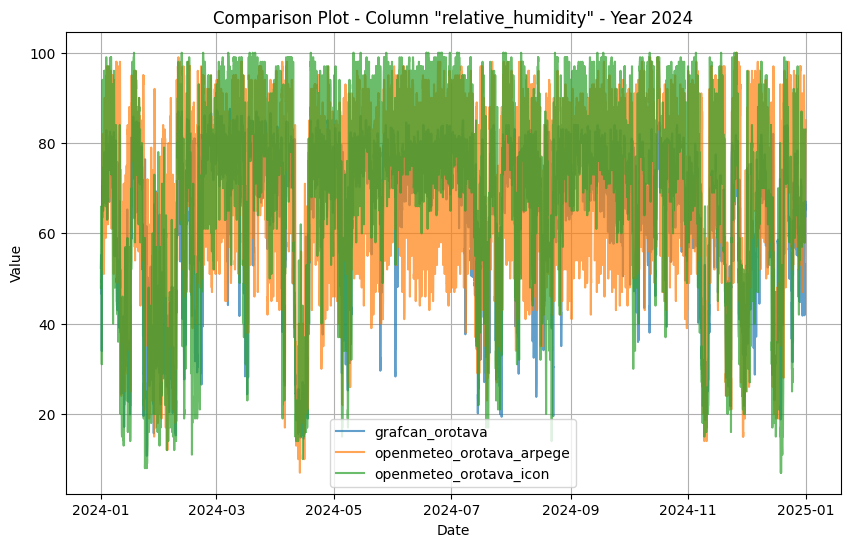

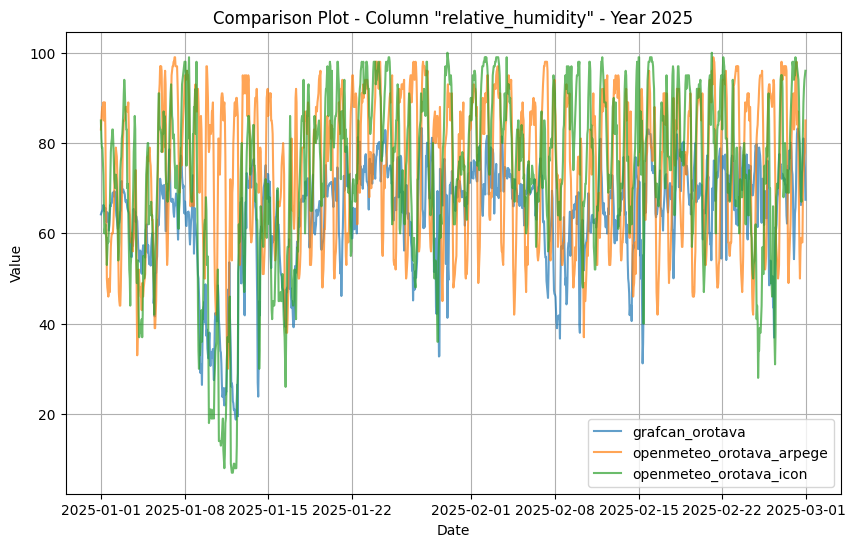

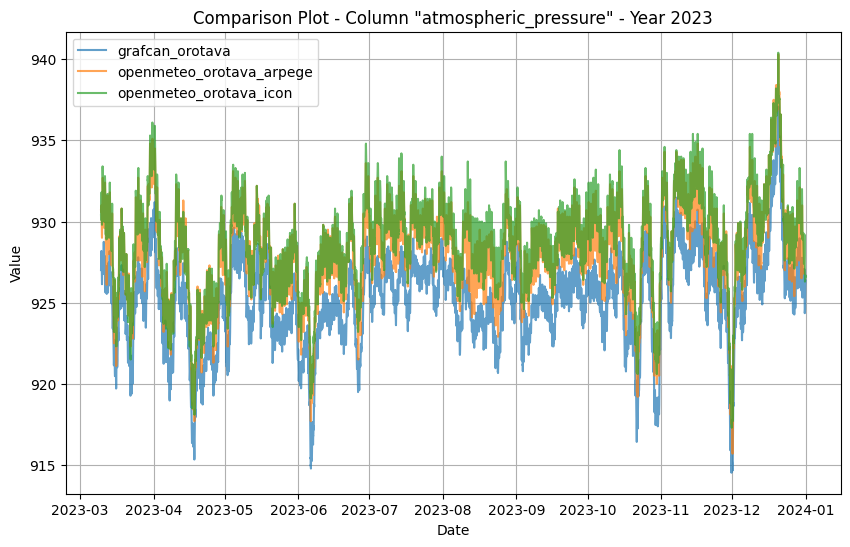

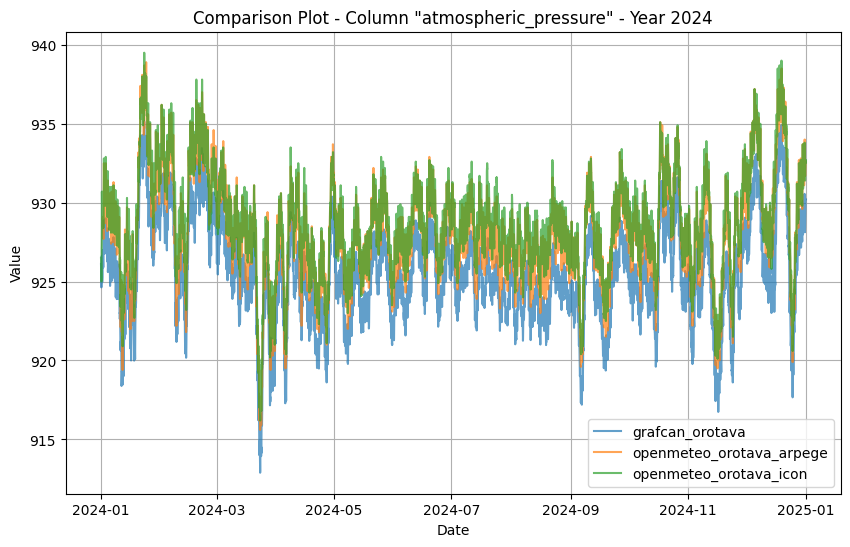

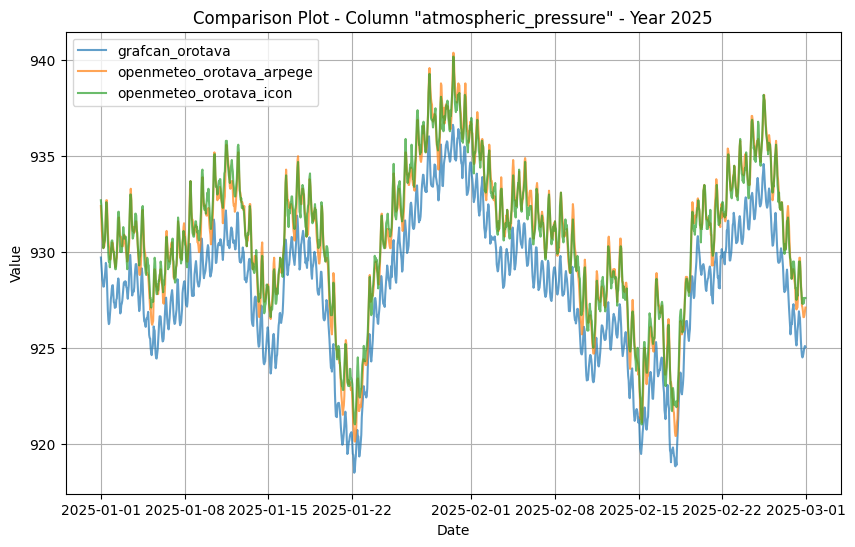

In [16]:
plot_datasets([orotava_grafcan, orotava_openmetoe_arpege, orotava_openmetoe_icon], "air_temperature")
plot_datasets([orotava_grafcan, orotava_openmetoe_arpege, orotava_openmetoe_icon], "relative_humidity")
plot_datasets([orotava_grafcan, orotava_openmetoe_arpege, orotava_openmetoe_icon], "atmospheric_pressure")

## Horas faltantes

In [17]:
    
for file_key, df_hourly in dataframes.items():
    # Check for missing hours in the time series
    # Detect missing hours after resampling
    missing_hours = df_hourly[df_hourly.isna().any(axis=1)].index

    # Print missing hours if any
    if len(missing_hours) > 0:
        print(f"Missing hours in {file_key} after resampling:")
        print(missing_hours.tolist())
        print(len(missing_hours))
    else:
        print(f"No missing hours in {file_key} after resampling.")

Missing hours in openmeteo_orotava_arpege after resampling:
[Timestamp('2023-12-31 07:00:00+0000', tz='UTC'), Timestamp('2023-12-31 08:00:00+0000', tz='UTC'), Timestamp('2023-12-31 09:00:00+0000', tz='UTC'), Timestamp('2023-12-31 10:00:00+0000', tz='UTC'), Timestamp('2023-12-31 11:00:00+0000', tz='UTC'), Timestamp('2023-12-31 12:00:00+0000', tz='UTC'), Timestamp('2023-12-31 13:00:00+0000', tz='UTC'), Timestamp('2023-12-31 14:00:00+0000', tz='UTC'), Timestamp('2023-12-31 15:00:00+0000', tz='UTC'), Timestamp('2023-12-31 16:00:00+0000', tz='UTC'), Timestamp('2023-12-31 17:00:00+0000', tz='UTC'), Timestamp('2023-12-31 18:00:00+0000', tz='UTC'), Timestamp('2023-12-31 19:00:00+0000', tz='UTC'), Timestamp('2023-12-31 20:00:00+0000', tz='UTC'), Timestamp('2023-12-31 21:00:00+0000', tz='UTC'), Timestamp('2023-12-31 22:00:00+0000', tz='UTC'), Timestamp('2023-12-31 23:00:00+0000', tz='UTC'), Timestamp('2024-01-01 00:00:00+0000', tz='UTC'), Timestamp('2024-01-01 01:00:00+0000', tz='UTC'), Timestam

### Manejo Horas faltantes

In [18]:
# Cubic Spline Interpolation Algorithm

def cubic_spline_interpolation(df):
 # Convert datetime index to a numeric format (Unix timestamp in seconds)
    numeric_index = df.index.astype(np.int64) // 10**9

    # Iterate over each feature column and apply cubic spline interpolation
    for col in df.columns:
        valid_mask = ~df[col].isna()
        # Check if there are enough valid points for interpolation
        if valid_mask.sum() >= 2:

            pchip = PchipInterpolator(numeric_index[valid_mask], df.loc[valid_mask, col])
            interpolated_values = pchip(numeric_index)

            #cs = CubicSpline(numeric_index[valid_mask], df.loc[valid_mask, col], bc_type='natural')
            #interpolated_values = cs(numeric_index)
            df[col] = df[col].fillna(pd.Series(interpolated_values, index=df.index))
        else:
            print(f"Not enough data points to interpolate column '{col}'.")
            
    return df

In [19]:
for file_key, df_hourly in dataframes.items():
    # Perform cubic spline interpolation on the dataframe
    cubic_spline_interpolation(df_hourly)

## Comparativa datasets predicciones

In [20]:
def datasets_similarity(file1, file2):
    # Remove .csv extension if present
    file1 = file1.replace(".csv", "")
    file2 = file2.replace(".csv", "")
    
    # Ensure datasets are loaded
    if file1 not in dataframes or file2 not in dataframes:
        print("One or both datasets are not loaded.")
        return
    
    # Retrieve dataframes and align by timestamp
    df1 = dataframes[file1]
    df2 = dataframes[file2]
    df1, df2 = df1.align(df2, join='inner')
    
    similarity_results = {}
    for column in df1.columns:
        if column in df2.columns:
            try:
                pearson_corr, _ = pearsonr(df1[column], df2[column])
                spearman_corr, _ = spearmanr(df1[column], df2[column])
                kendall_corr, _ = kendalltau(df1[column], df2[column])
                mse = mean_squared_error(df1[column], df2[column])
                euclid_dist = euclidean(df1[column], df2[column])
                
                similarity_results[column] = {
                    "Pearson": pearson_corr,
                    "Spearman": spearman_corr,
                    "Kendall": kendall_corr,
                    "MSE": mse,
                    "Euclidean Distance": euclid_dist
                }
            except Exception as e:
                print(f"Error calculating similarity for {column}: {e}")
    
    print(f"Similarity Metrics for {file1} vs {file2}")
    for col, metrics in similarity_results.items():
        print(f"  {col}:")
        for metric, value in metrics.items():
            print(f"    {metric}: {value:.4f}")


In [21]:
datasets_similarity(orotava_openmetoe_icon, orotava_grafcan)

Similarity Metrics for openmeteo_orotava_icon vs grafcan_orotava
  air_temperature:
    Pearson: 0.9246
    Spearman: 0.9218
    Kendall: 0.7618
    MSE: 3.0323
    Euclidean Distance: 229.2582
  atmospheric_pressure:
    Pearson: 0.9636
    Spearman: 0.9511
    Kendall: 0.8209
    MSE: 12.5371
    Euclidean Distance: 466.1599
  relative_humidity:
    Pearson: 0.7637
    Spearman: 0.6296
    Kendall: 0.4571
    MSE: 254.1122
    Euclidean Distance: 2098.6963


In [22]:
datasets_similarity(orotava_openmetoe_arpege, orotava_grafcan)

Similarity Metrics for openmeteo_orotava_arpege vs grafcan_orotava
  air_temperature:
    Pearson: 0.8099
    Spearman: 0.8194
    Kendall: 0.6340
    MSE: 7.5772
    Euclidean Distance: 362.4017
  atmospheric_pressure:
    Pearson: 0.9655
    Spearman: 0.9531
    Kendall: 0.8228
    MSE: 9.1333
    Euclidean Distance: 397.8785
  relative_humidity:
    Pearson: 0.4116
    Spearman: 0.2948
    Kendall: 0.2017
    MSE: 440.9257
    Euclidean Distance: 2764.5189


In [23]:
# Media de datasets openmeteo
dataframes["openmeteo_avg"] = (dataframes["openmeteo_orotava_arpege"] + dataframes["openmeteo_orotava_icon"]) / 2
datasets_similarity("openmeteo_avg", orotava_grafcan)

Similarity Metrics for openmeteo_avg vs grafcan_orotava
  air_temperature:
    Pearson: 0.8994
    Spearman: 0.9041
    Kendall: 0.7327
    MSE: 4.0103
    Euclidean Distance: 263.6492
  atmospheric_pressure:
    Pearson: 0.9692
    Spearman: 0.9581
    Kendall: 0.8323
    MSE: 10.6612
    Euclidean Distance: 429.8724
  relative_humidity:
    Pearson: 0.6776
    Spearman: 0.5507
    Kendall: 0.3872
    MSE: 245.4222
    Euclidean Distance: 2062.4993


## Detección de outliers



In [24]:
def detect_outliers_iqr(df, threshold=1.5, return_indices=False):
    """
    Detects and plots outliers in each numerical column of a Pandas DataFrame using the Interquartile Range (IQR) method.
    Optionally returns indices of the detected outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        threshold (float): The multiplier for the IQR to determine outlier boundaries.
        return_indices (bool): If True, also return a dictionary of outlier indices for each column.
        
    Returns:
        outliers_dict (dict): A dictionary containing outlier values for each numerical column.
        outlier_indices_dict (dict, optional): A dictionary containing outlier row indices for each numerical column.
    """
    outliers_dict = {}
    outlier_indices_dict = {}
    
    for column in df.select_dtypes(include=[np.number]).columns:
        # Calculate IQR-based bounds
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = outliers.tolist()
        outlier_indices_dict[column] = outliers.index.tolist()
        
        # Create subplots for boxplot and histogram
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        
        # Boxplot on the left with outliers highlighted
        ax1.boxplot(df[column], vert=False)
        ax1.scatter(outliers, [1] * len(outliers), color='red', label='Outliers')
        ax1.set_title(f'Boxplot of {column}')  # Fixed typo here
        ax1.set_xlabel(column)
        ax1.legend()
        
        # Histogram on the right with bounds indicated
        ax2.hist(df[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        ax2.axvline(lower_bound, color='red', linestyle='dashed', linewidth=1, label='Lower bound')
        ax2.axvline(upper_bound, color='red', linestyle='dashed', linewidth=1, label='Upper bound')
        ax2.set_title(f'Histogram of {column}')
        ax2.set_xlabel(column)
        ax2.set_ylabel('Frequency')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    if return_indices:
        return outliers_dict, outlier_indices_dict
    return outliers_dict


Processing openmeteo_orotava_arpege:


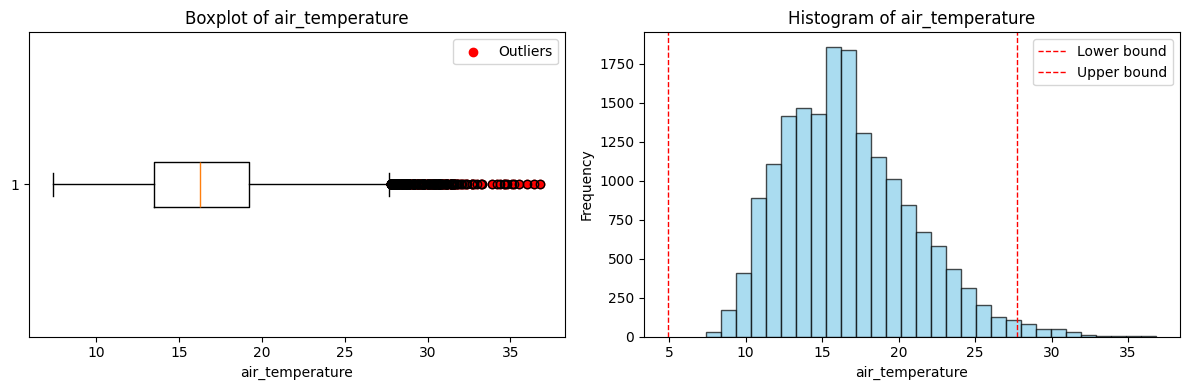

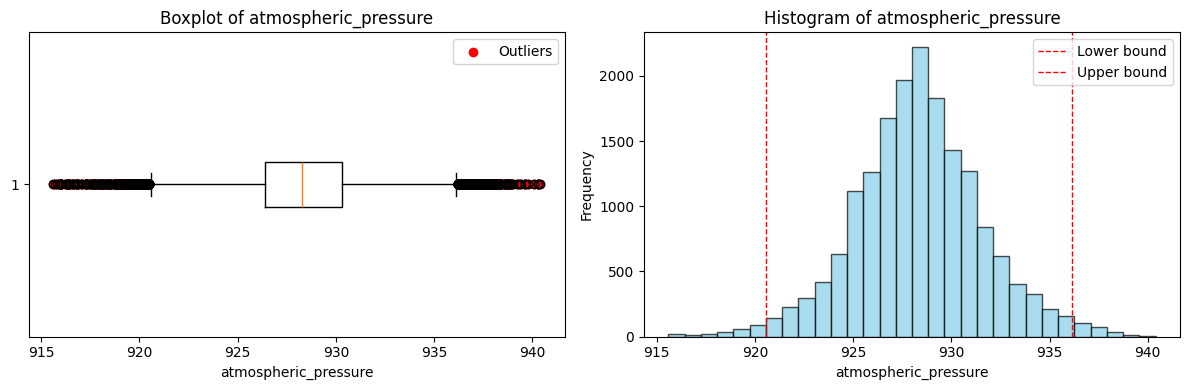

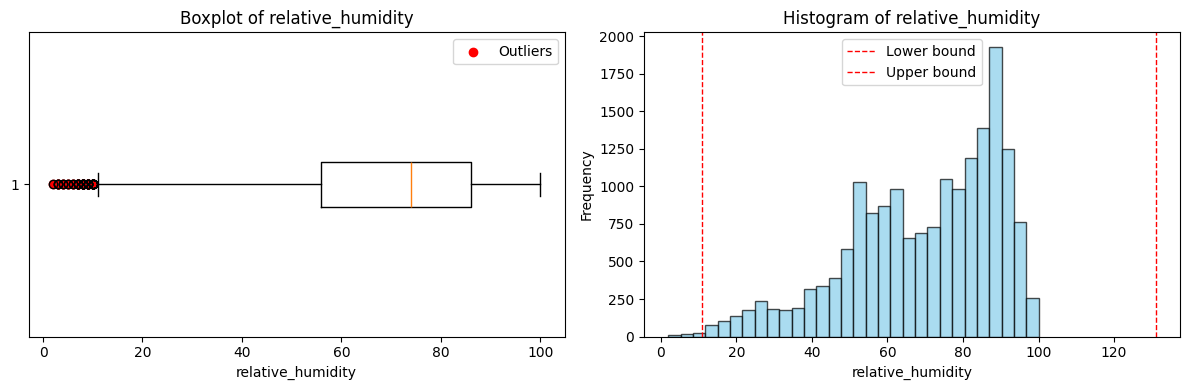

  air_temperature outlier row indices: [Timestamp('2023-03-29 13:00:00+0000', tz='UTC'), Timestamp('2023-03-29 14:00:00+0000', tz='UTC'), Timestamp('2023-03-29 15:00:00+0000', tz='UTC'), Timestamp('2023-06-28 11:00:00+0000', tz='UTC'), Timestamp('2023-06-28 12:00:00+0000', tz='UTC'), Timestamp('2023-06-28 13:00:00+0000', tz='UTC'), Timestamp('2023-06-28 14:00:00+0000', tz='UTC'), Timestamp('2023-06-28 15:00:00+0000', tz='UTC'), Timestamp('2023-06-28 16:00:00+0000', tz='UTC'), Timestamp('2023-06-28 17:00:00+0000', tz='UTC'), Timestamp('2023-06-29 10:00:00+0000', tz='UTC'), Timestamp('2023-06-29 11:00:00+0000', tz='UTC'), Timestamp('2023-06-29 12:00:00+0000', tz='UTC'), Timestamp('2023-06-29 13:00:00+0000', tz='UTC'), Timestamp('2023-06-29 14:00:00+0000', tz='UTC'), Timestamp('2023-06-29 15:00:00+0000', tz='UTC'), Timestamp('2023-07-04 14:00:00+0000', tz='UTC'), Timestamp('2023-07-04 15:00:00+0000', tz='UTC'), Timestamp('2023-07-04 16:00:00+0000', tz='UTC'), Timestamp('2023-07-11 12:00:0

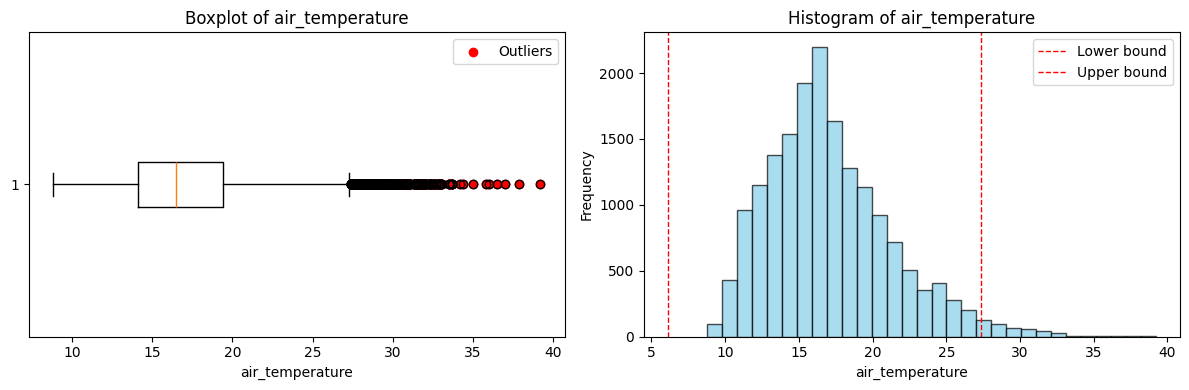

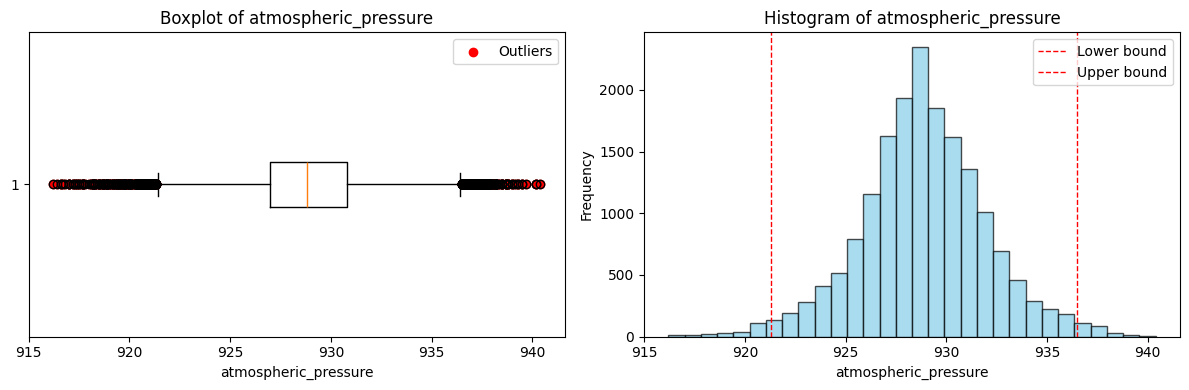

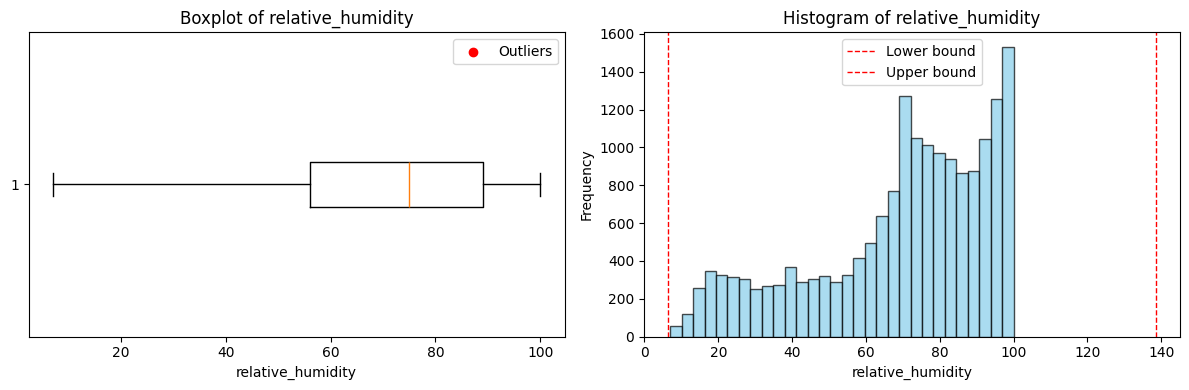

  air_temperature outlier row indices: [Timestamp('2023-03-30 11:00:00+0000', tz='UTC'), Timestamp('2023-03-30 12:00:00+0000', tz='UTC'), Timestamp('2023-03-30 13:00:00+0000', tz='UTC'), Timestamp('2023-03-30 14:00:00+0000', tz='UTC'), Timestamp('2023-03-30 15:00:00+0000', tz='UTC'), Timestamp('2023-03-30 16:00:00+0000', tz='UTC'), Timestamp('2023-03-30 18:00:00+0000', tz='UTC'), Timestamp('2023-03-31 10:00:00+0000', tz='UTC'), Timestamp('2023-03-31 11:00:00+0000', tz='UTC'), Timestamp('2023-03-31 12:00:00+0000', tz='UTC'), Timestamp('2023-03-31 13:00:00+0000', tz='UTC'), Timestamp('2023-03-31 14:00:00+0000', tz='UTC'), Timestamp('2023-03-31 15:00:00+0000', tz='UTC'), Timestamp('2023-03-31 16:00:00+0000', tz='UTC'), Timestamp('2023-03-31 17:00:00+0000', tz='UTC'), Timestamp('2023-03-31 18:00:00+0000', tz='UTC'), Timestamp('2023-06-27 12:00:00+0000', tz='UTC'), Timestamp('2023-06-27 13:00:00+0000', tz='UTC'), Timestamp('2023-06-27 14:00:00+0000', tz='UTC'), Timestamp('2023-06-27 15:00:0

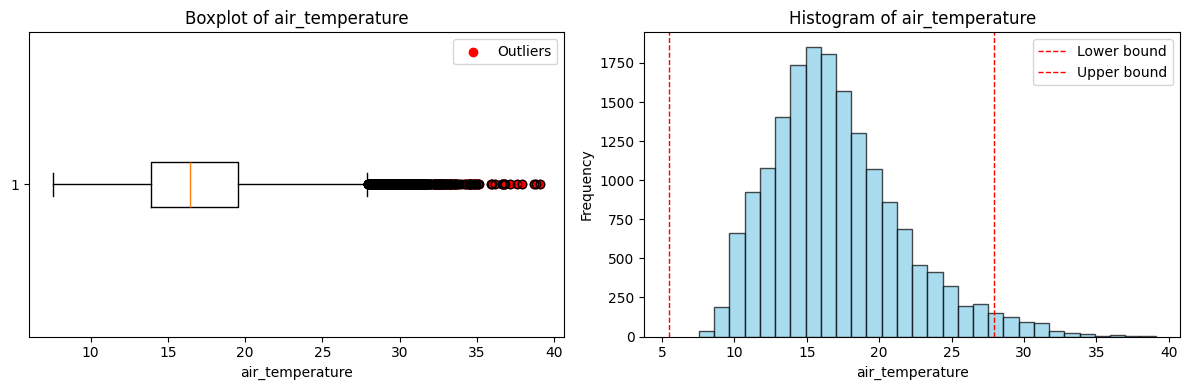

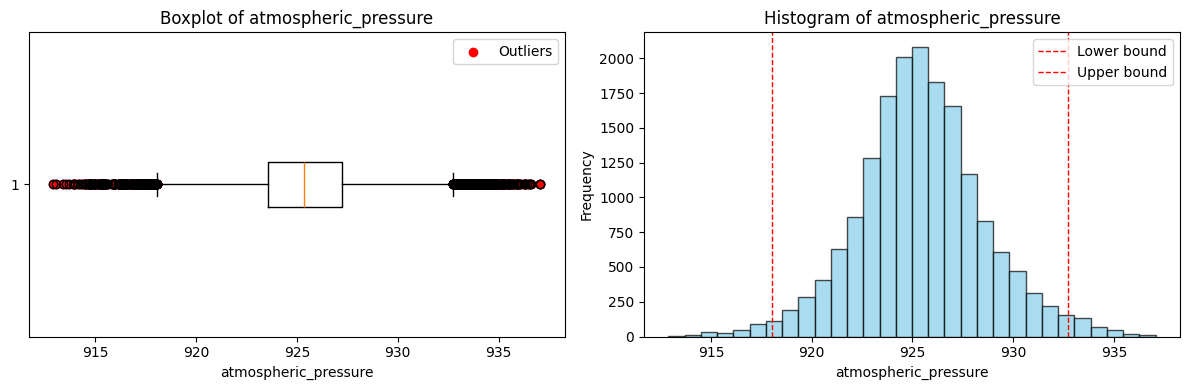

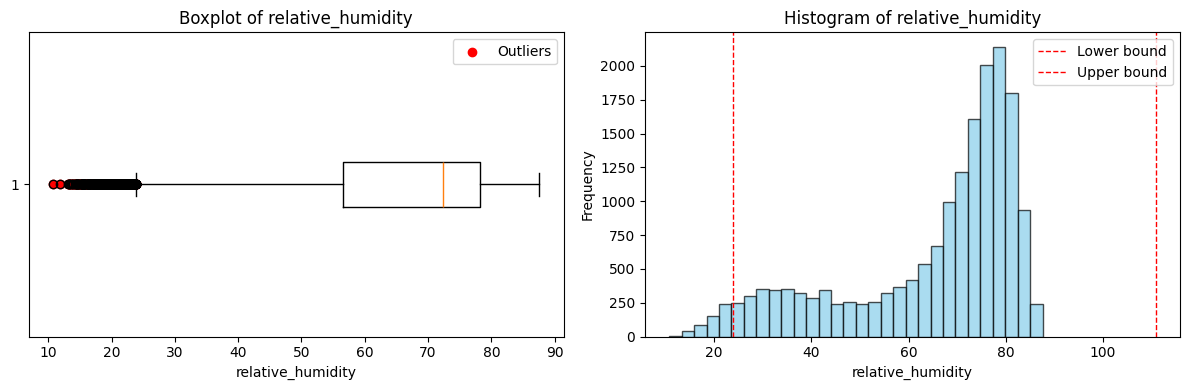

  air_temperature outlier row indices: [Timestamp('2023-03-12 11:00:00+0000', tz='UTC'), Timestamp('2023-03-12 12:00:00+0000', tz='UTC'), Timestamp('2023-03-25 16:00:00+0000', tz='UTC'), Timestamp('2023-03-25 17:00:00+0000', tz='UTC'), Timestamp('2023-03-26 10:00:00+0000', tz='UTC'), Timestamp('2023-03-26 11:00:00+0000', tz='UTC'), Timestamp('2023-03-26 12:00:00+0000', tz='UTC'), Timestamp('2023-03-26 13:00:00+0000', tz='UTC'), Timestamp('2023-03-26 14:00:00+0000', tz='UTC'), Timestamp('2023-03-30 13:00:00+0000', tz='UTC'), Timestamp('2023-03-30 14:00:00+0000', tz='UTC'), Timestamp('2023-03-30 15:00:00+0000', tz='UTC'), Timestamp('2023-03-31 08:00:00+0000', tz='UTC'), Timestamp('2023-03-31 09:00:00+0000', tz='UTC'), Timestamp('2023-03-31 10:00:00+0000', tz='UTC'), Timestamp('2023-03-31 11:00:00+0000', tz='UTC'), Timestamp('2023-03-31 12:00:00+0000', tz='UTC'), Timestamp('2023-03-31 13:00:00+0000', tz='UTC'), Timestamp('2023-03-31 14:00:00+0000', tz='UTC'), Timestamp('2023-03-31 15:00:0

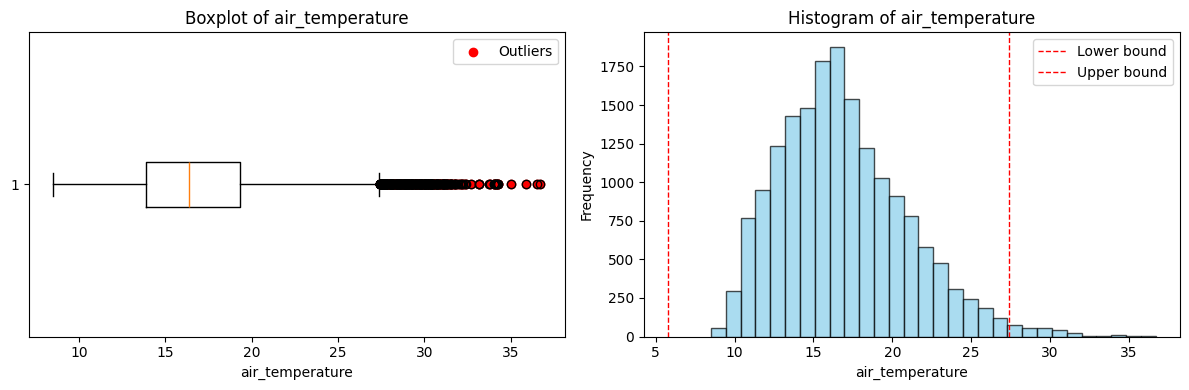

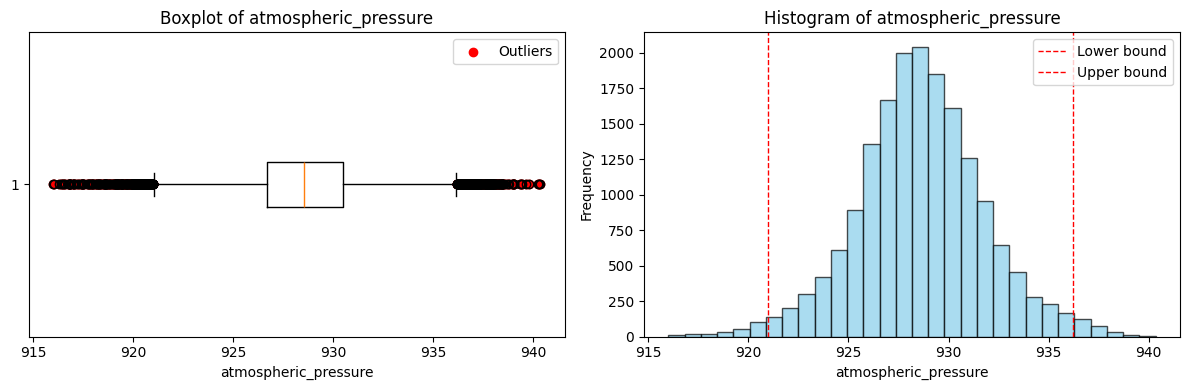

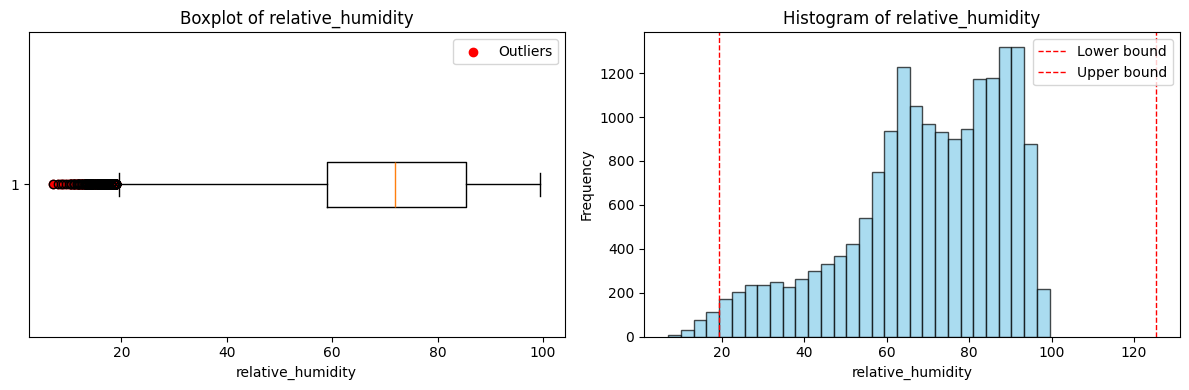

  air_temperature outlier row indices: [Timestamp('2023-03-30 13:00:00+0000', tz='UTC'), Timestamp('2023-03-30 14:00:00+0000', tz='UTC'), Timestamp('2023-03-30 15:00:00+0000', tz='UTC'), Timestamp('2023-03-30 16:00:00+0000', tz='UTC'), Timestamp('2023-03-31 12:00:00+0000', tz='UTC'), Timestamp('2023-03-31 13:00:00+0000', tz='UTC'), Timestamp('2023-03-31 14:00:00+0000', tz='UTC'), Timestamp('2023-03-31 15:00:00+0000', tz='UTC'), Timestamp('2023-03-31 16:00:00+0000', tz='UTC'), Timestamp('2023-06-28 11:00:00+0000', tz='UTC'), Timestamp('2023-06-28 12:00:00+0000', tz='UTC'), Timestamp('2023-06-28 13:00:00+0000', tz='UTC'), Timestamp('2023-06-28 14:00:00+0000', tz='UTC'), Timestamp('2023-06-28 15:00:00+0000', tz='UTC'), Timestamp('2023-06-28 16:00:00+0000', tz='UTC'), Timestamp('2023-06-29 10:00:00+0000', tz='UTC'), Timestamp('2023-06-29 11:00:00+0000', tz='UTC'), Timestamp('2023-06-29 12:00:00+0000', tz='UTC'), Timestamp('2023-06-29 13:00:00+0000', tz='UTC'), Timestamp('2023-06-29 14:00:0

In [25]:
threshold = 1.5

for file_key, df_hourly in dataframes.items():
    print(f"Processing {file_key}:")
    
    # Use the modified function to get both outlier values and their indices
    outliers, outlier_indices = detect_outliers_iqr(df_hourly, threshold, return_indices=True)
    
    # Print outliers for each column
    for column, indices in outlier_indices.items():
        print(f"  {column} outlier row indices: {indices}")
    
    # Combine all outlier indices from every column
    all_outlier_indices = set()
    for indices in outlier_indices.values():
        all_outlier_indices.update(indices)
    
    # Remove rows with any detected outlier
    #df_clean = df_hourly.drop(list(all_outlier_indices))
    #dataframes[file_key] = df_clean
    
    print(f"Removed {len(all_outlier_indices)} rows with outliers from {file_key}.\n")


In [26]:
## Exploración de frecuencias - Fourier

In [27]:
def plot_frequencies(df, column, freq_min, freq_max, top_n=3, sampling_interval=3600):
    values = df[column].values  # Extraer la columna de valores
    
    fft_result = np.fft.fft(values)  # Calcular la FFT
    frequencies = np.fft.fftfreq(len(values), d=sampling_interval)  # Calcular las frecuencias
    
    # Solo conservar las frecuencias positivas
    positive_frequencies = frequencies[:len(values) // 2]
    positive_fft_result = fft_result[:len(values) // 2]
    magnitude = np.abs(positive_fft_result)
    
    # Filtrar las frecuencias dentro del rango deseado
    mask = (positive_frequencies >= freq_min) & (positive_frequencies <= freq_max)
    filtered_frequencies = positive_frequencies[mask]
    filtered_magnitude = magnitude[mask]
    
    # Encontrar los índices de las N frecuencias con mayor magnitud
    top_indices = np.argsort(filtered_magnitude)[-top_n:]
    
    # Imprimir las N frecuencias principales
    print(f"Top {top_n} frequencies with highest magnitude:")
    for idx in top_indices:
        frequency_hz = filtered_frequencies[idx]
        period_hours = 1 / (frequency_hz * 3600)
        print(f"Frequency: {frequency_hz:.8f} Hz, Period: {period_hours:.2f} hours, Magnitude: {filtered_magnitude[idx]:.4f}")
    
    # Graficar el espectro de frecuencia con escala logarítmica en el eje X
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_frequencies, filtered_magnitude, label='Frequency Spectrum')
    
    # Resaltar las N frecuencias principales
    top_frequencies = filtered_frequencies[top_indices]
    top_magnitudes = filtered_magnitude[top_indices]
    plt.scatter(top_frequencies, top_magnitudes, color='red', zorder=5, label=f'Top {top_n} Frequencies')
    
    # Configurar escala logarítmica para el eje X
    plt.xscale('log')
    plt.xlabel('Frequency (Hz, log scale)')
    plt.ylabel('Magnitude')
    plt.title(f'Frequency Spectrum between {freq_min} Hz and {freq_max} Hz')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17333 entries, 2023-03-09 19:00:00+00:00 to 2025-02-28 23:00:00+00:00
Freq: h
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   air_temperature       17333 non-null  float64
 1   atmospheric_pressure  17333 non-null  float64
 2   relative_humidity     17333 non-null  float64
dtypes: float64(3)
memory usage: 541.7 KB
Top 5 frequencies with highest magnitude:
Frequency: 0.00000029 Hz, Period: 962.94 hours, Magnitude: 9076.4191
Frequency: 0.00000011 Hz, Period: 2476.14 hours, Magnitude: 10232.0919
Frequency: 0.00000024 Hz, Period: 1155.53 hours, Magnitude: 10279.4148
Frequency: 0.00001157 Hz, Period: 24.01 hours, Magnitude: 18340.2651
Frequency: 0.00000003 Hz, Period: 8666.50 hours, Magnitude: 25491.7230


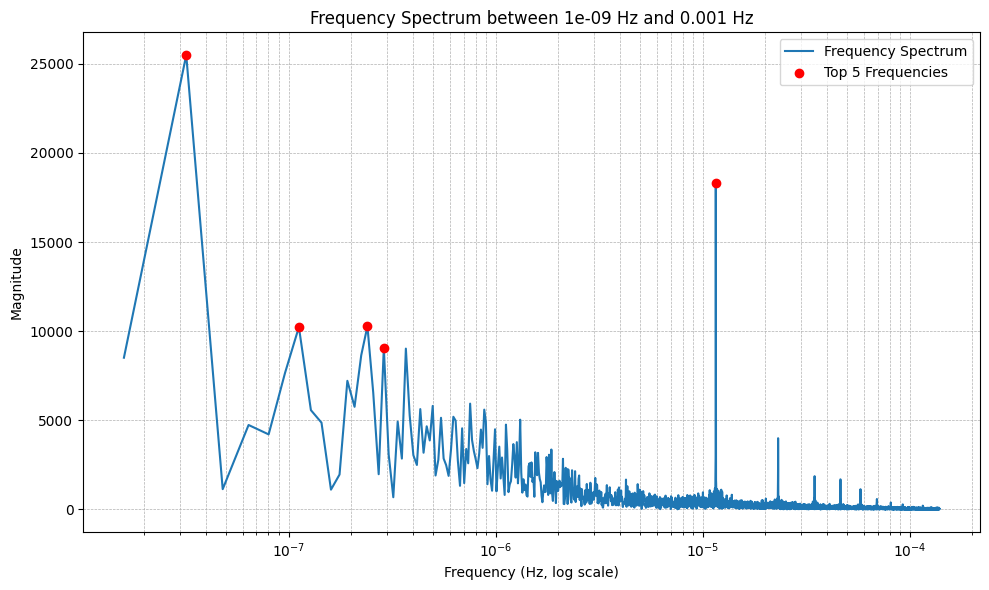

Top 5 frequencies with highest magnitude:
Frequency: 0.00000050 Hz, Period: 559.13 hours, Magnitude: 33447.0205
Frequency: 0.00001157 Hz, Period: 24.01 hours, Magnitude: 34077.4246
Frequency: 0.00000029 Hz, Period: 962.94 hours, Magnitude: 41724.1538
Frequency: 0.00000011 Hz, Period: 2476.14 hours, Magnitude: 42152.5172
Frequency: 0.00000003 Hz, Period: 8666.50 hours, Magnitude: 57755.9463


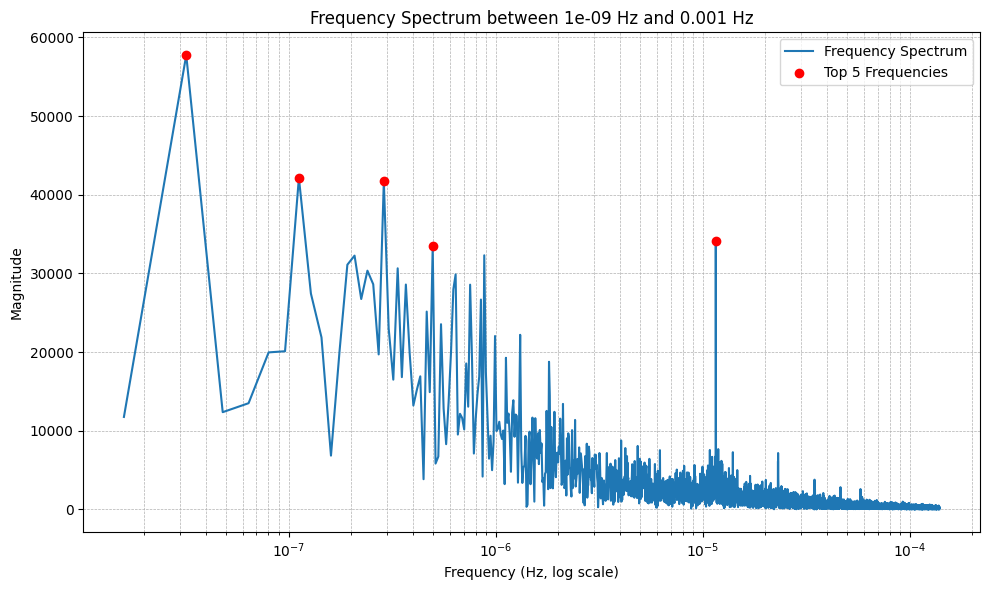

Top 5 frequencies with highest magnitude:
Frequency: 0.00000046 Hz, Period: 597.69 hours, Magnitude: 6468.6571
Frequency: 0.00000030 Hz, Period: 912.26 hours, Magnitude: 6500.0401
Frequency: 0.00000032 Hz, Period: 866.65 hours, Magnitude: 6940.2554
Frequency: 0.00000006 Hz, Period: 4333.25 hours, Magnitude: 10590.9690
Frequency: 0.00000003 Hz, Period: 8666.50 hours, Magnitude: 11977.7499


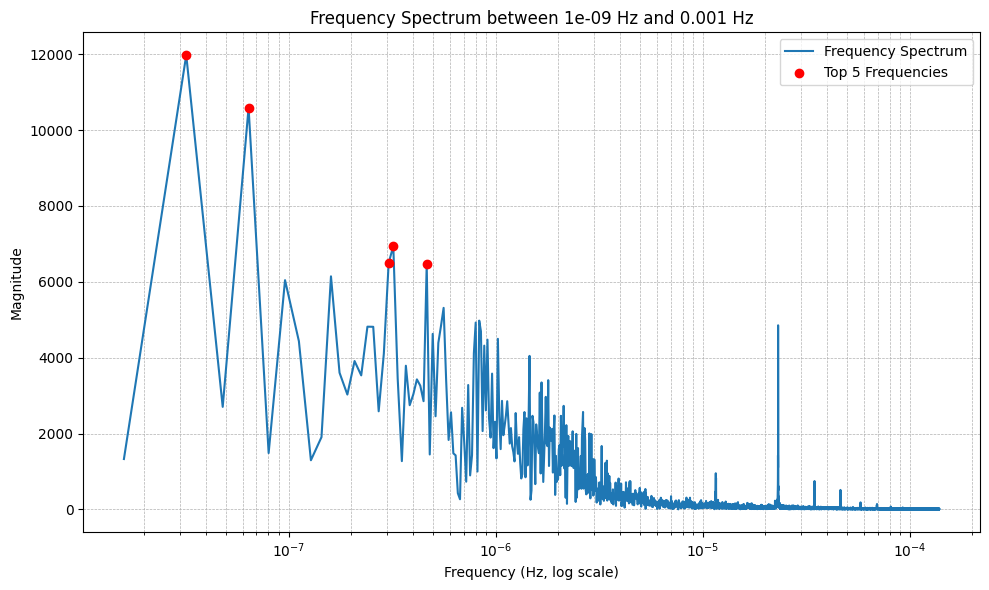

In [28]:
min_frequency = 10**-9
max_frequency = 10**-3
top_n = 5

dataframes["grafcan_orotava"].info()

plot_frequencies(dataframes["grafcan_orotava"], "air_temperature", min_frequency, max_frequency, top_n)
plot_frequencies(dataframes["grafcan_orotava"], "relative_humidity", min_frequency, max_frequency, top_n)
plot_frequencies(dataframes["grafcan_orotava"], "atmospheric_pressure", min_frequency, max_frequency, top_n)

## Datos temporales

In [29]:
# Extract hour and minute to get a more continuous representation of time within a day
df = dataframes["grafcan_orotava"].copy()
df.index.name = "time"
df.reset_index(inplace=True)

df['time'] = pd.to_datetime(df['time'])
hours = df['time'].dt.hour
minutes  = df['time'].dt.minute
hour_fraction = hours + minutes / 60.0

# Convert the hour fraction into sine and cosine features to capture cyclical patterns (period = 24 hours)
df['sin_day'] = np.sin(2 * np.pi * hour_fraction / 24)
df['cos_day'] = np.cos(2 * np.pi * hour_fraction / 24)

# Extract day of the week (0 = Monday, 6 = Sunday)
day_of_week = df['time'].dt.weekday

# Compute the continuous week fraction (e.g., Monday at noon = 0.5, Sunday at 23:59 = 6.999)
week_fraction = day_of_week + hour_fraction / 24.0  # Continuous representation of the week

# Encode the continuous week representation using sine and cosine (for weekly cycle, period = 7 days)
df['sin_week'] = np.sin(2 * np.pi * week_fraction / 7)
df['cos_week'] = np.cos(2 * np.pi * week_fraction / 7)

# For annual features: extract the day of the year (1-366)
day_of_year = df['time'].dt.dayofyear

# Create a continuous representation of the year:
# Subtracting 1 from day_of_year makes it start at 0, then add the fractional day.
year_fraction = (day_of_year - 1) + hour_fraction / 24.0

# Convert the continuous year representation into sine and cosine features (assuming period = 365 days)
df['sin_year'] = np.sin(2 * np.pi * year_fraction / 365)
df['cos_year'] = np.cos(2 * np.pi * year_fraction / 365)

# Remove original time variable
#df.drop(columns="time", inplace=True)


                          time  air_temperature  atmospheric_pressure  \
time                  1.000000        -0.209024              0.174872   
air_temperature      -0.209024         1.000000             -0.079255   
atmospheric_pressure  0.174872        -0.079255              1.000000   
relative_humidity    -0.014499        -0.533918             -0.141460   
sin_day              -0.000607        -0.162660             -0.015585   
cos_day              -0.000607        -0.310795             -0.023075   
sin_week              0.004569        -0.024096              0.013710   
cos_week             -0.004569        -0.000350             -0.020445   
sin_year             -0.183825        -0.370773              0.014335   
cos_year              0.354168        -0.258653              0.316498   

                      relative_humidity   sin_day   cos_day  sin_week  \
time                          -0.014499 -0.000607 -0.000607  0.004569   
air_temperature               -0.533918 -0.162660 

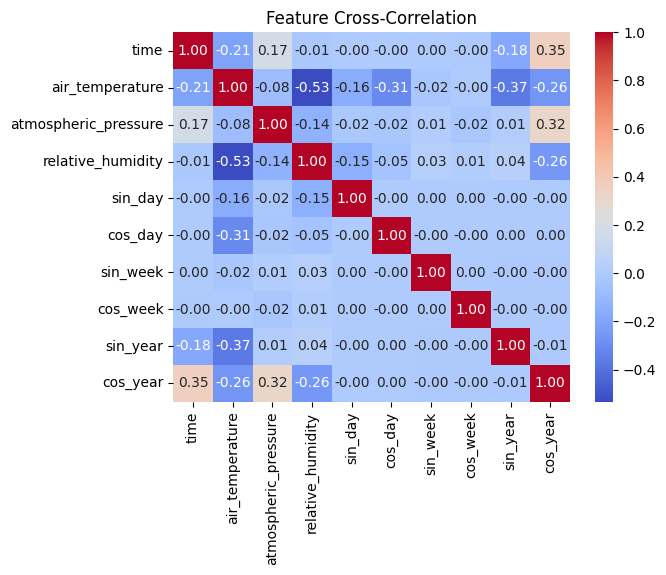

In [30]:
import seaborn as sns
# Compute correlation matrix
correlation_matrix = df.corr()

# Print correlation values
print(correlation_matrix)

# Heatmap for visualization
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Cross-Correlation")
plt.show()


In [32]:
df.drop(columns=["sin_week", "cos_week"], inplace=True)


## LSTM

In [33]:
import keras
import tensorflow as tf


# Test/Train split #
####################
target_day = '2025-01-01'

indices = df[df['time'].dt.date == pd.to_datetime(target_day).date()].index
first_2025_day_index = indices[0]
print(df.iloc[first_2025_day_index])

###################################################
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return [(data - data_mean) / data_std, data_mean, data_std]
#################################################

features = df.drop(columns=["time", "sin_day", "cos_day", "sin_year", "cos_year"])
normalized_features, mean, std = normalize(features.values, first_2025_day_index)
normalized_features = pd.DataFrame(normalized_features, columns=features.columns)
normalized_features["sin_day"] = df["sin_day"]
normalized_features["cos_day"] = df["cos_day"]
normalized_features["sin_year"] = df["sin_year"]
normalized_features["cos_year"] = df["cos_year"]
print("Normalized: ", normalized_features.head())

train_data = normalized_features.loc[0 : first_2025_day_index]
val_data = normalized_features.loc[first_2025_day_index:]

# Training data structure #
###########################
past = 30
HOURS_TO_FORECAST = 3
future = HOURS_TO_FORECAST

# Labels start after past data
label_start = past
label_end = label_start + first_2025_day_index

x_train = train_data
# y_train = normalized_features.iloc[label_start:label_end]
y_train = normalized_features.iloc[label_start:label_end].drop(columns=["sin_day", "cos_day", "sin_year", "cos_year"])
y_train_multi = np.array([y_train[i:i+future] for i in range(len(y_train) - future + 1)])

# Validation data structure #
#############################
x_val_end = len(val_data) - past - future
val_label_start = first_2025_day_index + past

x_val = val_data.iloc[:x_val_end]
# y_val = normalized_features.iloc[val_label_start:]
y_val = normalized_features.iloc[val_label_start:].drop(columns=["sin_day", "cos_day", "sin_year", "cos_year"])
y_val_multi = np.array([y_val[i:i+future] for i in range(len(y_val) - future + 1)])

# Parameters #
##############
learning_rate = 0.001
batch_size =128
epochs = 10
step = 1 

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train_multi,
    sequence_length=past,
    sampling_rate=step,
    batch_size=batch_size,
)

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val_multi,
    sequence_length=past,
    sampling_rate=step,
    batch_size=batch_size,
)

tf.data.Dataset.save(dataset_train, "dataset_train_orotava")
tf.data.Dataset.save(dataset_val, "dataset_val_orotava")


for batch_x, batch_y in dataset_train.take(1):  # Take the first batch
    print("First batch X:", batch_x.numpy())
    print("First batch Y:", batch_y.numpy())



2025-03-26 00:50:46.660108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742950246.679003  135701 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742950246.685585  135701 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-26 00:50:46.707641: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


time                    2025-01-01 00:00:00+00:00
air_temperature                          10.44864
atmospheric_pressure                   929.709157
relative_humidity                       64.197504
sin_day                                       0.0
cos_day                                       1.0
sin_year                                      0.0
cos_year                                      1.0
Name: 15917, dtype: object
Normalized:     air_temperature  atmospheric_pressure  relative_humidity   sin_day  \
0        -0.083903              0.608623          -0.129481 -0.965926   
1        -0.146519              0.703256          -0.502289 -0.866025   
2        -0.117238              0.875200          -0.796440 -0.707107   
3        -0.204987              0.944095          -1.121035 -0.500000   
4        -0.297789              1.003267          -1.297780 -0.258819   

    cos_day  sin_year  cos_year  
0  0.258819  0.919568  0.392931  
1  0.500000  0.919850  0.392271  
2  0.707107  0.9201

I0000 00:00:1742950250.113040  135701 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 71 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1


First batch X: [[[-8.39028504e-02  6.08623135e-01 -1.29481095e-01 ...  2.58819045e-01
    9.19568039e-01  3.92930810e-01]
  [-1.46518819e-01  7.03255871e-01 -5.02289045e-01 ...  5.00000000e-01
    9.19849636e-01  3.92271141e-01]
  [-1.17238266e-01  8.75199594e-01 -7.96439684e-01 ...  7.07106781e-01
    9.20130759e-01  3.91611270e-01]
  ...
  [ 3.79284128e-02  1.13625871e+00 -1.49742041e+00 ...  8.66025404e-01
    9.27004622e-01  3.75049904e-01]
  [ 2.88446384e-02  1.19142878e+00 -1.69110724e+00 ...  9.65925826e-01
    9.27273391e-01  3.74384906e-01]
  [ 9.12129854e-02  1.10787842e+00 -1.96551194e+00 ...  1.00000000e+00
    9.27541684e-01  3.73719715e-01]]

 [[-1.46518819e-01  7.03255871e-01 -5.02289045e-01 ...  5.00000000e-01
    9.19849636e-01  3.92271141e-01]
  [-1.17238266e-01  8.75199594e-01 -7.96439684e-01 ...  7.07106781e-01
    9.20130759e-01  3.91611270e-01]
  [-2.04987156e-01  9.44094923e-01 -1.12103487e+00 ...  8.66025404e-01
    9.20411409e-01  3.90951197e-01]
  ...
  [ 2.88

2025-03-26 00:50:51.335699: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 30, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           297 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 3, 3)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,417 (21.16 KB)

 Trainable params: 5,417 (21.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/750
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5264
Epoch 1: val_loss improved from inf to 0.18854, saving model to model_checkpoint.weights.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.5231 - val_loss: 0.1885 - learning_rate: 0.0050
Epoch 2/750
118/125 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1775
Epoch 2: val_loss improved from 0.18854 to 0.13126, saving model to model_checkpoint.weights.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1758 - val_loss: 0.1313 - learning_rate: 0.0050
Epoch 3/750
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1447
Epoch 3: val_loss improved from 0.13126 to 0.11298, saving model to model_checkpoint.weights.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1445 - val_loss: 0.1130 - learning_rate: 0.0050
Epoch 4/750
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1272
Epoch 4: val_loss improved from 0.11298 to 0.09586, saving model to model_checkpoint.weights.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.

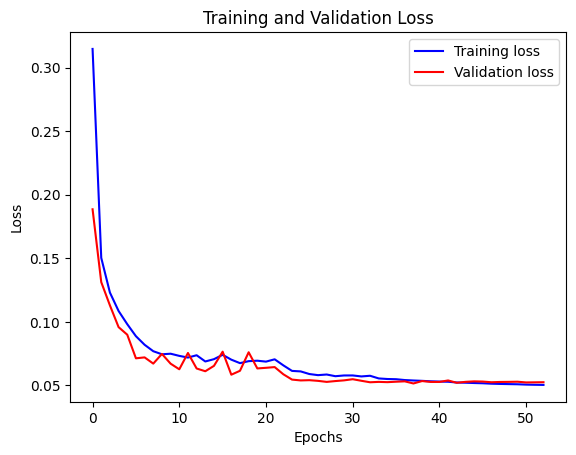

In [35]:
############
# Training #
epochs = 750
learning_rate = 0.005

dataset_train = tf.data.Dataset.load("dataset_train_orotava")
dataset_val = tf.data.Dataset.load("dataset_val_orotava")

for batch in dataset_train.take(1):
    inputs, targets = batch
    
#print("here?")

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
# lstm_out = keras.layers.LayerNormalization()(lstm_out) 

#lstm_out = keras.layers.Bidirectional(keras.layers.LSTM(64))(inputs)

#lstm_out = keras.layers.Bidirectional(keras.layers.LSTM(16, return_sequences=True))(inputs)
#lstm_out = keras.layers.Bidirectional(keras.layers.LSTM(16))(lstm_out)

# lstm_out = keras.layers.LSTM(256, return_sequences=True)(inputs)
# lstm_out = keras.layers.LayerNormalization()(lstm_out) 
# # lstm_out = keras.layers.LSTM(32, return_sequences=True)(lstm_out)
# lstm_out = keras.layers.LSTM(128)(lstm_out)


# Ensure the Dense layer outputs the correct shape
#lstm_out = keras.layers.Dense(16, activation='tanh')(lstm_out)
output_units = targets.shape[1] * targets.shape[2]  # Flatten output shape
outputs = keras.layers.Dense(output_units)(lstm_out)

# Reshape to match the target shape
outputs = keras.layers.Reshape((targets.shape[1], targets.shape[2]))(outputs)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

path_checkpoint = "model_checkpoint.weights.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=15)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

# Added reduce on plateau
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.7,         # reduce LR by a factor of 0.5
    patience=4,         # wait for 5 epochs before reducing
    verbose=1,
    min_lr=1e-7,
    min_delta=0.00001
)


history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    #callbacks=[es_callback, modelckpt_callback],
    callbacks=[es_callback, modelckpt_callback, reduce_lr_callback],
    #callbacks=[modelckpt_callback, reduce_lr_callback],
    
)

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

Index(['air_temperature', 'atmospheric_pressure', 'relative_humidity'], dtype='object')
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


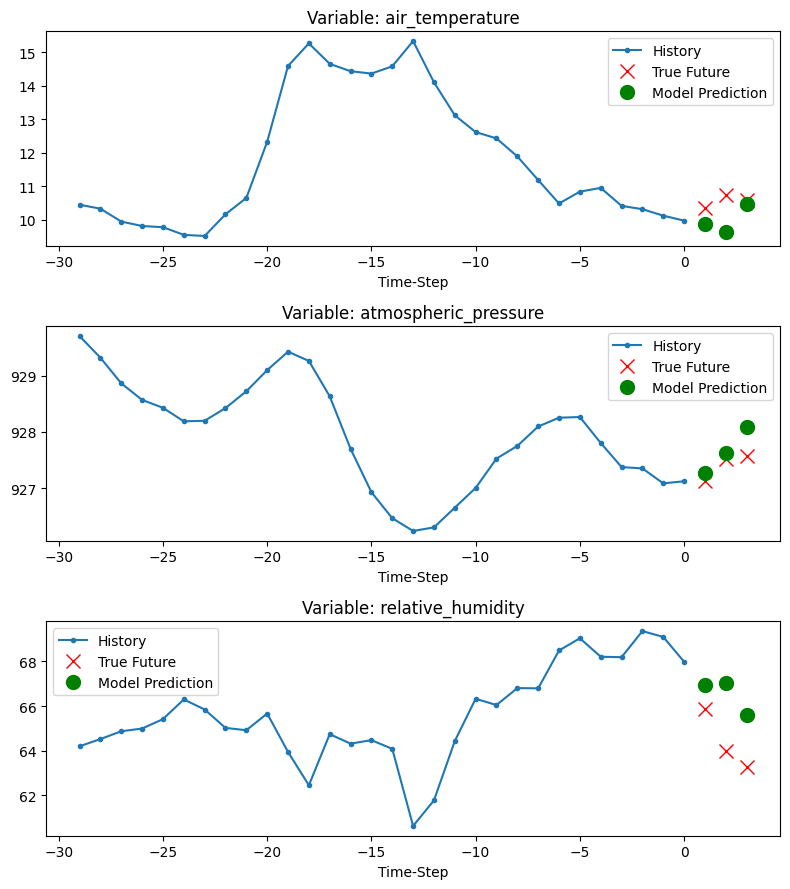

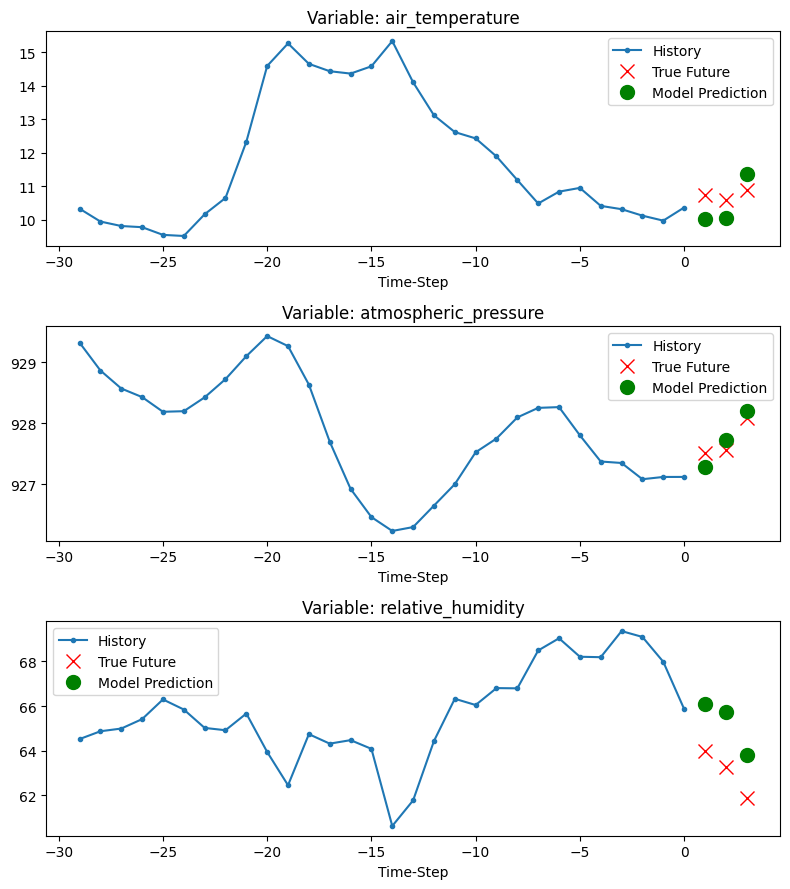

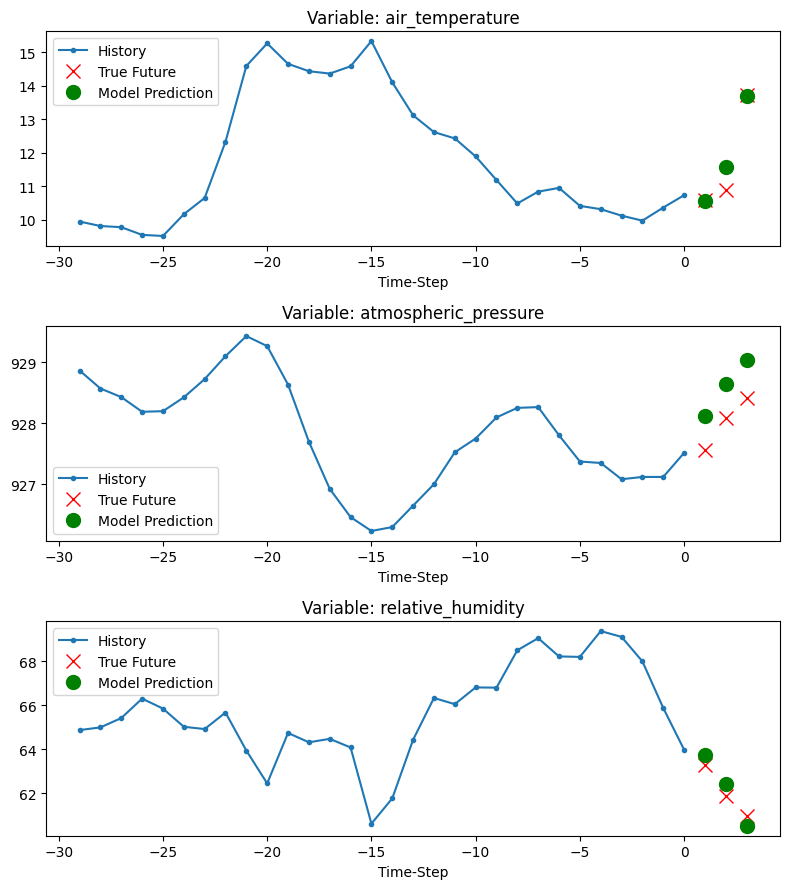

2025-03-26 00:57:29.356536: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [36]:
def show_plots_for_variables(plot_data, delta, feature_names, mean, std):
    """
    Plots separate graphs for each variable, showing the 3 forecast points in true scale.
    
    Parameters:
    - plot_data: List containing [history, true future, model prediction].
    - delta: Time step offset for forecasts.
    - feature_names: List of feature names for labeling each subplot.
    - mean: Mean values for each feature (for denormalization).
    - std: Standard deviation values for each feature (for denormalization).
    """
    labels = ["History", "True Future", "Model Prediction"]
    markers = [".-", "rx", "go"]
    num_variables = plot_data[0].shape[1]  # Number of features

    fig, axes = plt.subplots(num_variables, 1, figsize=(8, num_variables * 3))

    if num_variables == 1:
        axes = [axes]  # Ensure axes is iterable for a single variable

    for i in range(num_variables):
        ax = axes[i]

        # Convert normalized values back to real scale
        history = plot_data[0][:, i] * std[i] + mean[i]
        true_future = plot_data[1][:, i] * std[i] + mean[i]
        prediction = plot_data[2][:, i] * std[i] + mean[i]

        time_steps = list(range(-len(history)+ 1, 1))
        ax.plot(time_steps, history, markers[0], label=labels[0])

        # Plot forecasts
        forecast_time = list(range(delta + 1, delta + len(true_future) + 1))
        ax.plot(forecast_time, true_future, markers[1], markersize=10, label=labels[1])
        ax.plot(forecast_time, prediction, markers[2], markersize=10, label=labels[2])

        ax.set_title(f"Variable: {feature_names[i]}")
        ax.set_xlabel("Time-Step")
        ax.legend()
    
    plt.tight_layout()
    plt.show()


# Extract feature names (assuming dataset has feature names available)
feature_names = features.columns[:3]  # Modify if real names exist
print(feature_names)

# Assuming `mean` and `std` are arrays with the same length as the number of features
for x, y in dataset_val.take(1):
    prediction = model.predict(x)
    show_plots_for_variables([x[0][:, :3].numpy(), y[0].numpy(), prediction[0]], 0, feature_names, mean, std)
    show_plots_for_variables([x[1][:, :3].numpy(), y[1].numpy(), prediction[1]], 0, feature_names, mean, std)
    show_plots_for_variables([x[2][:, :3].numpy(), y[2].numpy(), prediction[2]], 0, feature_names, mean, std)
    
    



## Escritura fichero 

In [31]:
for file_key, df_hourly in dataframes.items():
  print(df_hourly.describe())

       air_temperature  atmospheric_pressure  relative_humidity
count     17544.000000          17544.000000       17544.000000
mean         16.689093            928.327964          69.534912
std           4.224121              3.260439          19.769734
min           7.400000            915.600000           2.000000
25%          13.500000            926.400000          56.000000
50%          16.300000            928.300000          74.000000
75%          19.200000            930.300000          86.000000
max          36.800000            940.400000         100.000000
       air_temperature  atmospheric_pressure  relative_humidity
count     17544.000000          17544.000000       17544.000000
mean         17.079138            928.863019          69.303295
std           4.190274              3.140440          23.818533
min           8.800000            916.200000           7.000000
25%          14.100000            927.000000          56.000000
50%          16.500000            928.80